## Bike Sharing Demand

### Import Libraries

In [140]:
import pandas as pd      # for data manipulation and analysis
import numpy as np       # for numerical computing
import matplotlib.pyplot as plt     # for data visualization
import matplotlib.dates as mdates   
import seaborn as sns    # for advanced data visualization
import sklearn           # for machine learning algorithms
import statsmodels.api as sm        # for statistical models and tests
import scipy.stats as stats         # for scientific computing and statistics
import random


# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from termcolor import colored
import pylab
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Import Data

In [141]:
# Set the file path and name
train_path = './data/train.csv'
test_path = './data/test.csv'

# Read the CSV file into a Pandas DataFrame
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Copy of datasets
train = train_df
test = test_df

### Auxiliar Functions

In [142]:
# Function to print main info about the dataset

def ds_info(df):
    print(colored('SIZE' , 'blue', attrs=['bold', 'dark']))
    print(df.size)
    print(colored('\nSHAPE' , 'blue', attrs=['bold', 'dark']))
    print(df.shape)
    print(colored('\nINFO' , 'blue', attrs=['bold', 'dark']))
    print(df.info())
    print(colored('\nNULL VALUES' , 'blue', attrs=['bold', 'dark']))
    print(df.isnull().sum())
    print(colored('\nHEAD' , 'blue', attrs=['bold', 'dark']))
    print(df.head())
    print(colored('\nTAIL' , 'blue', attrs=['bold', 'dark']))
    print(df.tail())
    print(colored('\nDESCRIBE - Numerical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe())
    print(colored('\nDESCRIBE - Categorical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe(include='object'))
    
    print(colored('\nUNIQUE ENTRIES IN EACH NUMERICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with numerical data
    num_cols = [col for col in df.columns if df[col].dtype != "object"]
    num_nunique = list(map(lambda col: df[col].nunique(), num_cols))    
    dn = dict(zip(num_cols, num_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dn.items(), key=lambda x: x[1]))
    
    print(colored('\nUNIQUE ENTRIES IN EACH CATEGORICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with categorical data
    object_cols = [col for col in df.columns if df[col].dtype == "object"]
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    dc = dict(zip(object_cols, object_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dc.items(), key=lambda x: x[1]))

# Function to detect and print outliers 
def detect_outliers(data):
    # mean, standard deviation and 3-sigma of the data
    mean = np.mean(data)
    std = np.std(data)
    threesigma = 3 * std
    
    # print upper, lower boundary and boxplot
    sns.boxplot(data, orient="v")
    plt.show()
    lower, upper = mean-3*std, mean+3*std
    print(f"Upper and lower boundary is: {lower}/{upper}")
    
    # identify outliers and return the outliers
    outliers = [x for x in data if np.abs(x - mean) > threesigma]
    print(f"There are {len(outliers)} outliers based on three-sigma rule")

# Function to delete the outliers 
def delete_outliers(data, df):
    # detecting and dropping outliers 
    original_shape = df.shape
    mean = np.mean(data)
    std = np.std(data)
    outliers = np.abs(data-mean) > (3*std)
    outliers_num = len(train[outliers])
    df.drop(index=data[outliers].index, inplace=True)
    
    # print what was deleted
    print("Number of outliers deleted:", outliers_num)
    print ("Shape of dataframe with Ouliers: ",original_shape)
    print ("Shape of Dataframe After Deleting the Ouliers: ",df.shape)

# Function to plot the Correlation Heatmap
def correlation_heatmap(corr):
    mask = np.array(corr)
    mask[np.tril_indices_from(mask)] = False
    # plot the correlation
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)
    sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

### Data Information

#### Features

**datetime** - hourly date + timestamp <br>
**season** -  season of the year (1 = spring, 2 = summer, 3 = fall, 4 = winter) <br>
**holiday** - whether the day is considered a holiday (1: holiday, 0: not a holiday) <br>
**workingday** - whether the day is neither a weekend nor holiday (1: working day, 0: not a working day) <br>
**weather:** <br>
  1: Clear, Few clouds, Partly cloudy, Partly cloudy <br>
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  <br>
**temp** - temperature in Celsius <br>
**atemp** - "feels like" temperature in Celsius <br>
**humidity** - relative humidity <br>
**windspeed** - wind speed <br>
**casual** - number of non-registered user rentals initiated <br>
**registered** - number of registered user rentals initiated <br>
**count**   - number of total rentals <br>

#### Train Dataset Information

In [91]:
ds_info(train)

SIZE
130632

SHAPE
(10886, 12)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None

NULL VALUES
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype

#### Test Dataset Information

In [92]:
ds_info(test)

SIZE
58437

SHAPE
(6493, 9)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB
None

NULL VALUES
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

HEAD
              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  201

## Feature Engineering

As demonstraded previusly, the **datetime** feature is type object, so it must be converted to type datetime. 
Also, some features such as season, holiday, weather and humidity are type int, but they are actually categorical data.

In [143]:
train.datetime = pd.to_datetime(train.datetime)   # convert train.datetime to type datetime 
test.datetime = pd.to_datetime(test.datetime)     # convert test.datetime to type datetime 

In [144]:
train["season"] = train.season.map({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter" })
train["weather"] = train.weather.map({1:"Clear",\
                                        2:"Cloudy", \
                                        3:"Light Snow/Rain", \
                                        4:"Heavy Rain/Snow"})

#### Converting to categorical data

In [145]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday

In [146]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    train[var] = train[var].astype("category")

The column **datetime** is not neccessary anymore and can be dropped

In [147]:
train = train.drop(['datetime'], axis=1)

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  int64   
 12  month       10886 non-null  category
 13  day         10886 non-null  int64   
 14  hour        10886 non-null  category
 15  weekday     10886 non-null  category
dtypes: category(7), float64(3), int64(6)
memory usage: 842.1 KB


#### Missing values

An important part of the cleaning and feature engineering process is finding the the missing values of the dataset, but based on previus evaluation using isnull we were able to see the dataset provided doesn't have null values. Let's see is after the feature engineering something changed:

In [99]:
print(train.isnull().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
weekday       0
dtype: int64


All column still have all values not null, so this project will consider no missing values, but some data with zero value in columns such as windspeed could be evaluated to confirm if the 0 is a missing value. 

### Outliers

[Text(0.5, 0, 'Weather'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Count by Weather')]

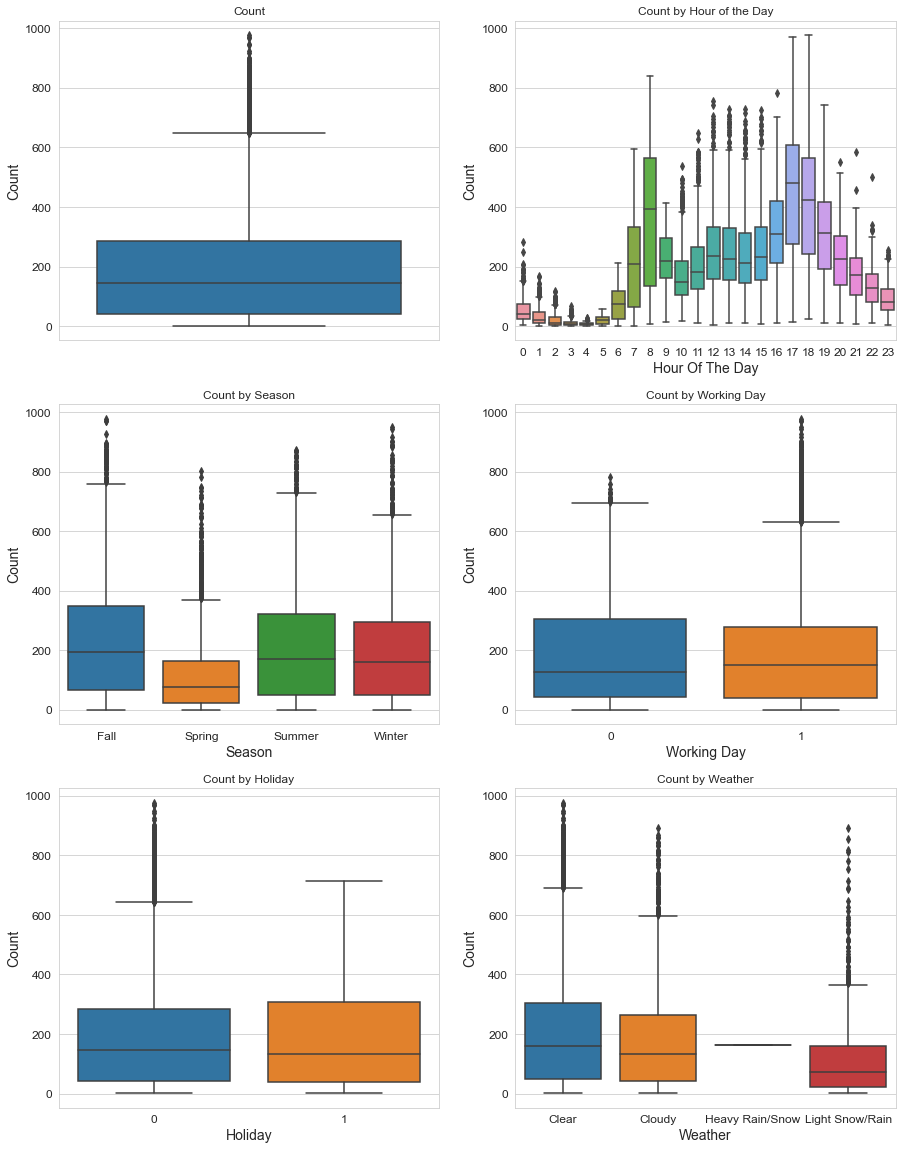

In [149]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 20)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=train,y="count",x="holiday",orient="v",ax=axes[2][0])
sns.boxplot(data=train,y="count",x="weather",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Count")
axes[0][1].set(xlabel='Hour Of The Day', ylabel='Count',title="Count by Hour of the Day")
axes[1][0].set(xlabel='Season', ylabel='Count',title="Count by Season")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Count by Working Day")
axes[2][0].set(xlabel='Holiday', ylabel='Count',title="Count by Holiday")
axes[2][1].set(xlabel='Weather', ylabel='Count',title="Count by Weather")
#axes[2][1].set_xticklabels([])


- datetime - hourly date + timestamp
- season - season of the year (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- holiday - whether the day is considered a holiday (1: holiday, 0: not a holiday)
- workingday - whether the day is neither a weekend nor holiday (1: working day, 0: not a working day)
- weather:
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


Analysis
- The comparison between seasons show spring is the one with lower number of bike rent.
- The boxplot with meaninful information is the Hour of the day, because it shows the busiest hours are 7AM - 8AM and 5PM - 6PM, which means the users mainly rent the bikes to ride to work/school and to return back home at the end of the day.
- Based on boxplots 4 and 5 (Working Day and Holiday), we see most outliers are in working days. The result make sense when looking to Holiday, since all outliers are for non holidays days.
- The last boxploy demonstrates the obvious common sense that most users rent bikes when the weather is Clear and Cloudy (1 and 2), and almost no users when is heavy raining or snowing (3).
- The season with lower number of rentals is oddly Spring and not Winter, but this will be explained further in Visualization.

#### Removing Outliers

It will be used the Three-sigma rule to remove the outliers, also known as the "68-95-99.7 rule". Tree-sigma is a statistical principle that states that for a normal distribution of data, approximately 68% of the data will fall within one standard deviation of the mean, about 95% will fall within two standard deviations, and about 99.7% will fall within three standard deviations.

In practice, this means that if we have a data point that falls outside of three standard deviations from the mean, it is considered an outlier and may be removed from the dataset. This approach assumes that the data follows a normal distribution and that outliers are rare events that are unlikely to occur in the future.

C:\Users\peter\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\peter\Anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


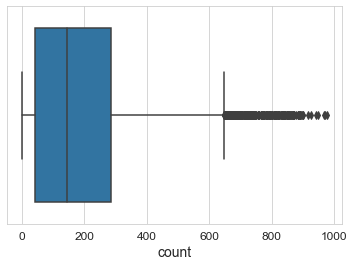

Upper and lower boundary is: -351.8342688102485/734.982532635345
There are 147 outliers based on three-sigma rule


In [101]:
detect_outliers(train['count'])

In [102]:
delete_outliers(train['count'], train)

Number of outliers deleted: 147
Shape of dataframe with Ouliers:  (10886, 16)
Shape of Dataframe After Deleting the Ouliers:  (10739, 16)


### Correlation Analysis

In [103]:
corr_variables = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()

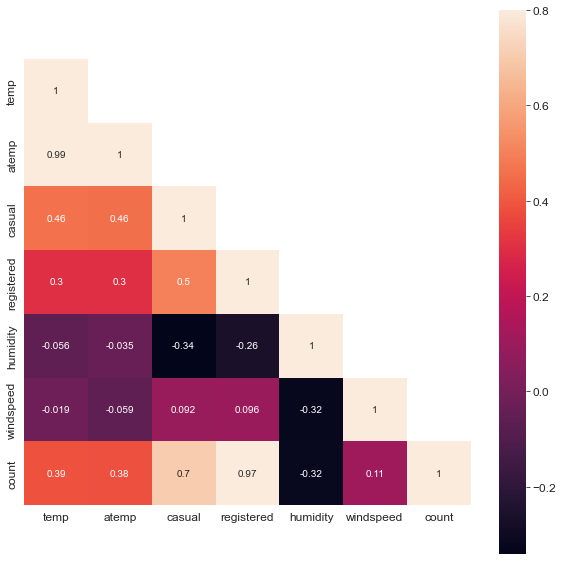

In [104]:
correlation_heatmap(corr_variables)

In [117]:
#plt.figure(figsize=(16,8))
#sns.pairplot(train)
#plt.show()

<AxesSubplot:xlabel='registered', ylabel='count'>

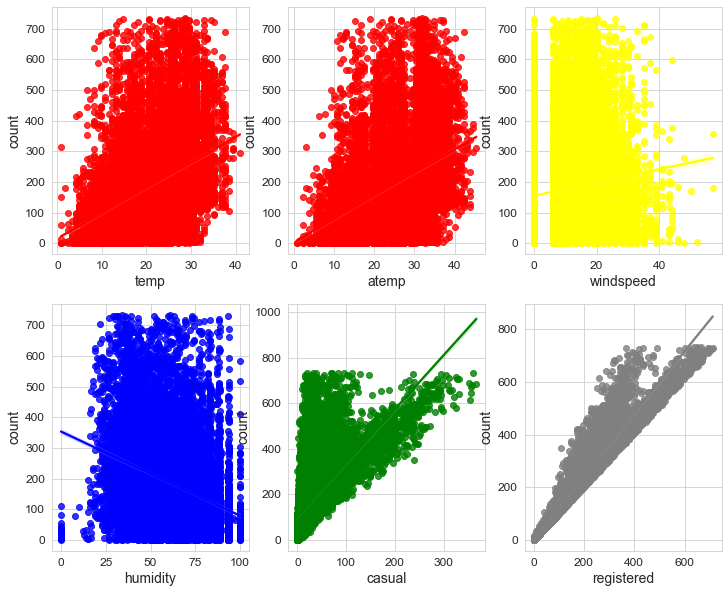

In [136]:
fig,axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(12, 10)
sns.regplot(x="temp", y="count", data=train,ax=axes[0][0], color="red")
sns.regplot(x="atemp", y="count", data=train,ax=axes[0][1], color="red")
sns.regplot(x="windspeed", y="count", data=train,ax=axes[0][2], color="yellow")
sns.regplot(x="humidity", y="count", data=train,ax=axes[1][0], color="blue")
sns.regplot(x="casual", y="count", data=train,ax=axes[1][1], color="green")
sns.regplot(x="registered", y="count", data=train,ax=axes[1][2], color="gray")


Analysis:

In this analisys, it was correlated count with the variables temp, atemp, casual, registered, humidity, windspeed. These are main conclusions found:
- The correlation between count and temp (and atemp) is low it seems to have little dependency on count
- Since count is the result of casual and registerd, we can see correlation of casual agains temp and registered agains temp, we see that registered users have a lower correlation with temperature than casual user, wich makes sense, since the casual users rent the bike for leasure purposes and probably only when the weather is pleasant.
- Temp and atemp have a strong correlation, which in this case could configure multicolinearity in the model, so one of them could be removed from the final model.
- Windspeed doesn't correlate well with any variables, which means probably doesn't have any impact in count
- The last two graphs are only to demonstrate count is more affected by registered users, but cannot be used in the final model because would not be available at the time of making the predictions, and are also considered leakage variables.

### Visualization

As explained previusly, COUNT is the result of REGISTERED and CASUAL count, and the graphs below demonstrates the different patterns by hour. The COUNT is similiar to REGISTERED, but because most of user are registered, and their busier times are between 7-8 AM and 4-5 PM, while the busier times for casual users are better distributed during the day, but busiest time betteen 1-2 PM.   

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Casual Count'),
 Text(0.5, 1.0, 'Box Plot On Casual Count Across Hour Of The Day')]

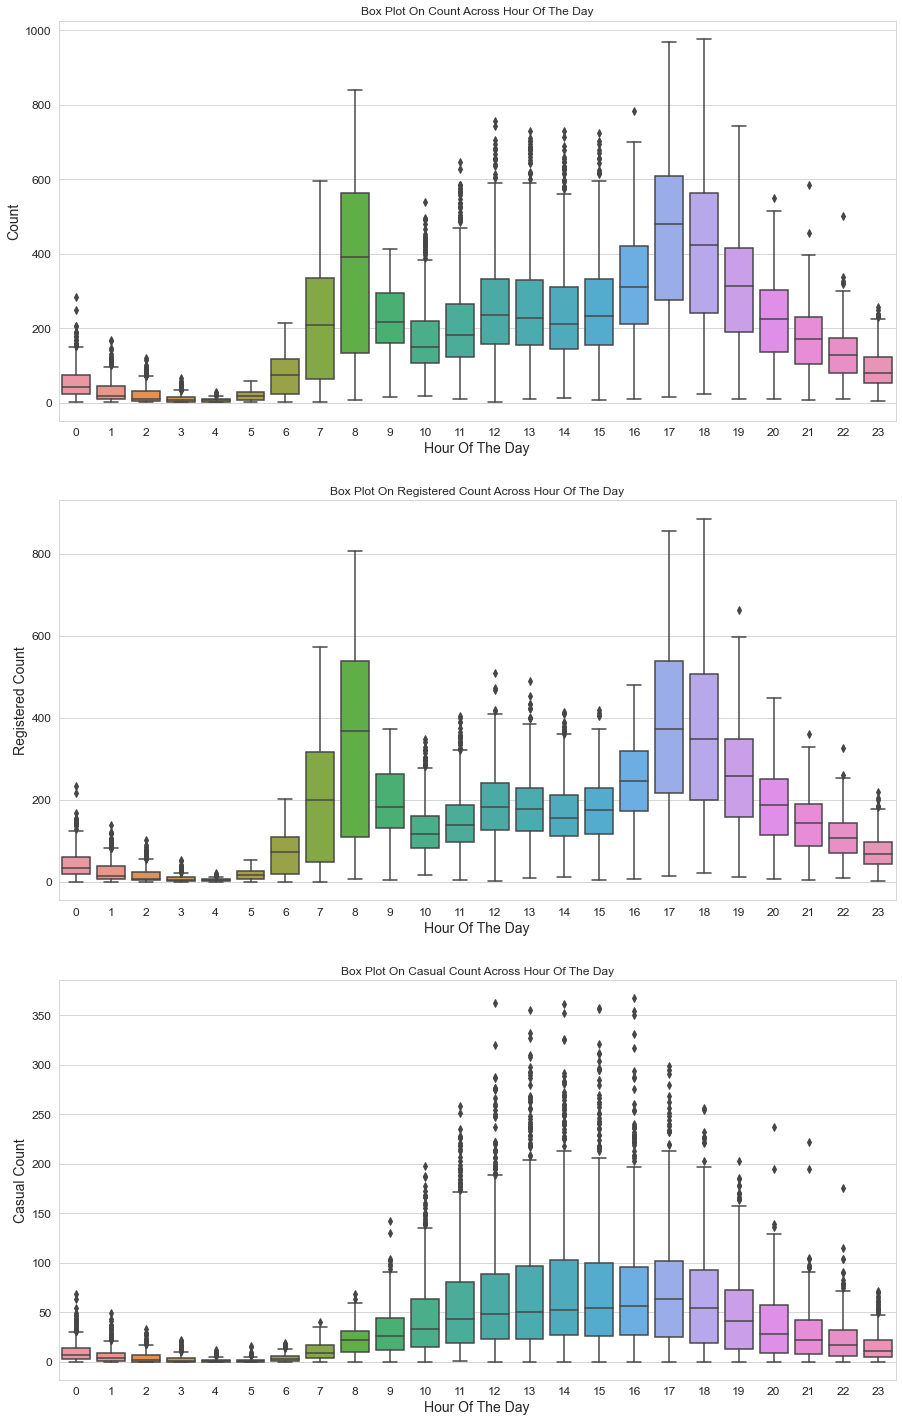

In [173]:
# boxplot of Count, Registered and Casual users by hour
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(15, 25)

sns.boxplot(data=train,y="count",x="hour",orient="v", ax=axes[0])
sns.boxplot(data=train,y="registered",x="hour",orient="v", ax=axes[1])
sns.boxplot(data=train,y="casual",x="hour",orient="v",ax=axes[2])

axes[0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1].set(xlabel='Hour Of The Day', ylabel='Registered Count',title="Box Plot On Registered Count Across Hour Of The Day")
axes[2].set(xlabel='Hour Of The Day', ylabel='Casual Count',title="Box Plot On Casual Count Across Hour Of The Day")

The graph below demonstraits why the season with less rentals is Sprint. Among all season, Spring is the one with highest number of Heavy Rain/Snow days, which impacts directly in less rental demand. 

Text(0.5, 0.98, 'Weather count across Seasons')

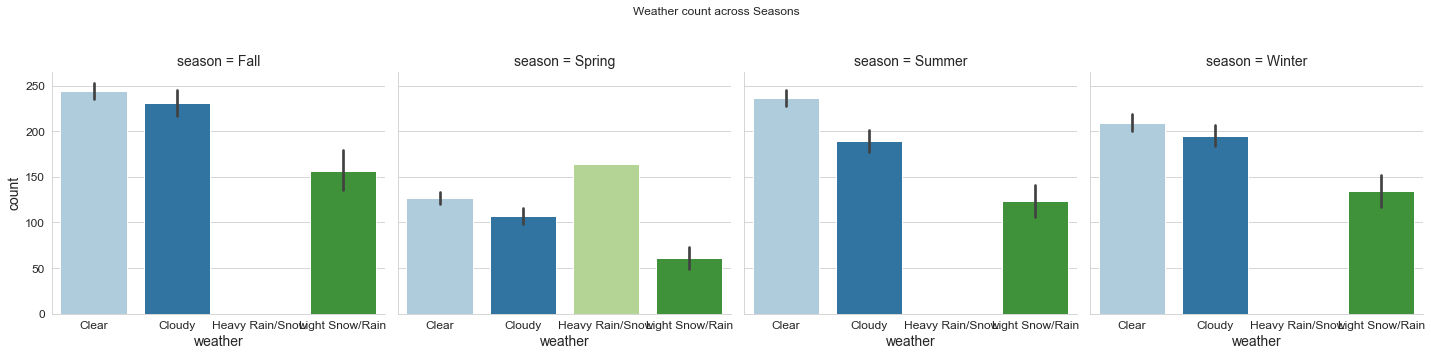

In [180]:
# weather count across seasons
g = sns.catplot(x='weather', y='count', col='season', kind="bar", palette="Paired", data=train)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Weather count across Seasons")

[Text(0.5, 0, 'Hour of the Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Count of Registered vs Casual by Hour of the Day')]

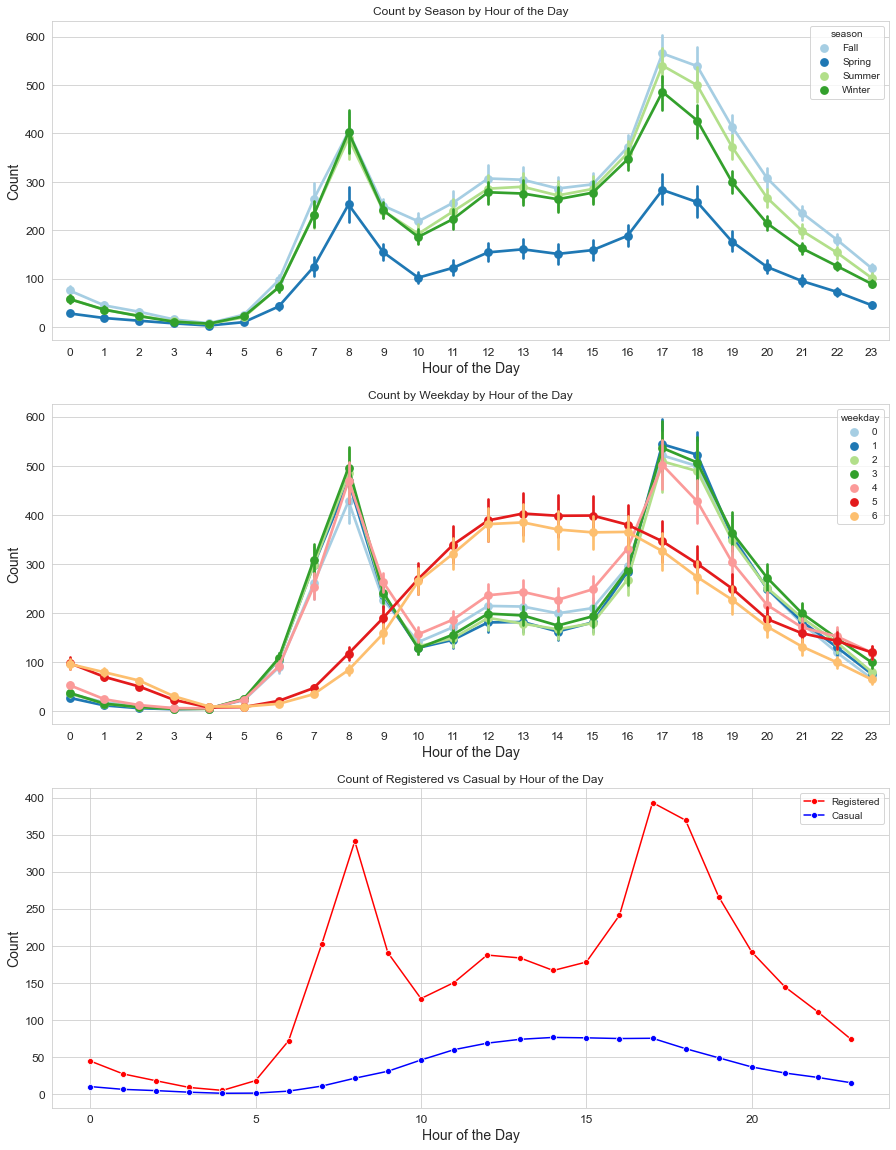

In [186]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(15,20)
sns.pointplot(x='hour',y='count',hue='season',join=True, data=train, palette="Paired", ax=ax1)
sns.pointplot(x='hour',y='count',hue='weekday',join=True, data=train, palette="Paired", ax=ax2)
sns.lineplot(x='hour', y='registered', data=train, color='red',label='Registered', marker='o', ax=ax3, ci=None)
sns.lineplot(x='hour', y='casual', data=train, color='blue', label='Casual', marker='o', ax=ax3, ci=None)
ax3.set_ylabel('Count')

ax1.set(xlabel='Hour of the Day', ylabel='Count',title="Count by Season by Hour of the Day")
ax2.set(xlabel='Hour of the Day', ylabel='Count',title="Count by Weekday by Hour of the Day")
ax3.set(xlabel='Hour of the Day', ylabel='Count',title="Count of Registered vs Casual by Hour of the Day")

#### Working Days

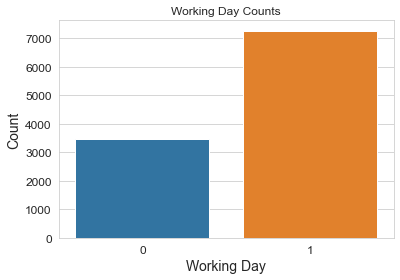

In [106]:
# Data by workingday and count the number of records in each group
workingday_counts = train.groupby('workingday')['count'].count()

# Bar chart using seaborn
sns.barplot(x=workingday_counts.index, y=workingday_counts.values)
sns.set_style('whitegrid')
plt.title('Working Day Counts')
plt.xlabel('Working Day')
plt.ylabel('Count')
plt.show()

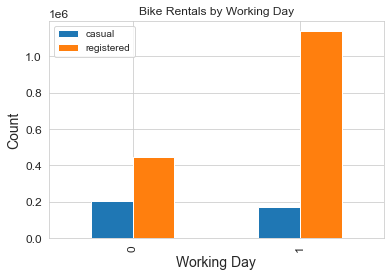

In [107]:
rentals_by_workingday = train.groupby('workingday')[['casual', 'registered']].sum()

# Create a bar chart using seaborn
rentals_by_workingday.plot(kind='bar')
sns.set_style('whitegrid')
plt.title('Bike Rentals by Working Day')
plt.xlabel('Working Day')
plt.ylabel('Count')
plt.show()

#### Season

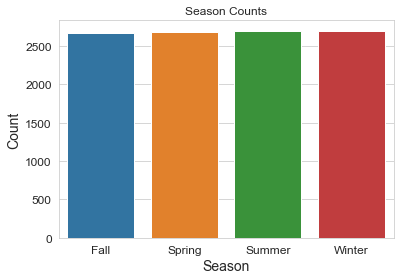

In [108]:
season_counts = train.groupby('season')['count'].count()

sns.barplot(x=season_counts.index, y=season_counts.values)
sns.set_style('whitegrid')
plt.title('Season Counts')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

The graph shows that all seasons have a similar number of count

### Weather

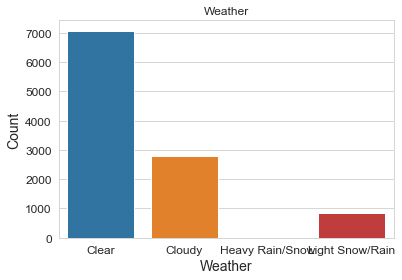

In [109]:
# Data by workingday and count the number of records in each group
weather_counts = train.groupby('weather')['count'].count()

# Bar chart using seaborn
sns.barplot(x=weather_counts.index, y=weather_counts.values)
sns.set_style('whitegrid')
plt.title('Weather')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.show()

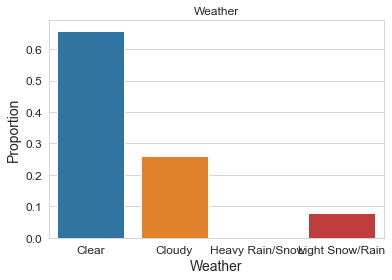

In [110]:
# Get the value counts of the "weather" column
weather_counts = train['weather'].value_counts(normalize=True).sort_values(ascending=True)

# Create a vertical bar plot using seaborn
ax = sns.barplot(x=weather_counts.index, y=weather_counts.values)
ax.set_title('Weather')
ax.set_xlabel('Weather')
ax.set_ylabel('Proportion')

plt.show()

Analysis:
- More than 65% of the rentals are during the weather 1 (Clear, Few clouds, Partly cloudy, Partly cloudy)
- More the 25% of the rentals are in 2 (Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist)
- And only 8% rent in weather 3 (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds)
- No one rents when is Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

### Temperature

In [111]:
# Select a random year between 2011 and 2012
year = random.randint(2011, 2012)

# Extract the data for the selected year
start_date = str(year) + '-01-01'
end_date = str(year) + '-01-02'
mask = (train['datetime'] >= start_date) & (train['datetime'] <= end_date)
year_data = train.loc[mask]

# Create a line plot of count data for the selected year
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(year_data['datetime'], year_data['count'])

# Set the x-axis locator and formatter to show every 4 hours
hours_6 = mdates.HourLocator(interval=12)
date_fmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_locator(hours_6)
ax.xaxis.set_major_formatter(date_fmt)

ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Count Data for Random Year: ' + str(year))
plt.show()

KeyError: 'datetime'